In [1]:
%matplotlib inline
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

from torchsummary import summary
import torch
from torch import nn, optim
from torch.autograd import Variable
import time
from time import strftime, localtime
import copy
import random

In [2]:
torch.cuda.get_device_name(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Datasets

Set 1: mixture of randomly generated sines and sine-gaussians within sensible parameters ranges and NO noise.

## Training

- 100 mixed signals + clean/target sources signals

In [3]:
# Parameters

T = 180     # 3 min of data, sampled every 0.1 s
fs = 10
N = T*fs
t = np.linspace(0,T,N)

# These vary..

freq_sin = np.random.uniform(0.0, 1.0, 1000)                # frequency of sine wave
phase_shift_sin = np.random.uniform(0.0, 2.0*np.pi, 1000)    # phase of sine wave
t0_sg = np.random.uniform(0.0, T, 1000)                      # pulse starting time of sine gaussian

# These are fixed

a = 0.1             #amplitude, phase, frequency and tau of sine gaussian
phi0 = np.pi
f0 = 0.5
tau = 10.0

### Time series

In [4]:
# Time Series

ts_s_train = np.zeros((1000,N))
ts_sg_train = np.zeros((1000,N))

# noise
# noise = np.random.normal(loc=0.0, scale=10.0, size=1000)

for i in range(1000):
    
    ts_s_train[i,:] = a*np.sin(2*np.pi*freq_sin[i]*t + phase_shift_sin[i]) #+ noise
    ts_sg_train[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*f0*(t-t0_sg[i])+phi0)) #+ noise
    
    ts_mix_train = ts_s_train + ts_sg_train

(1000, 1800)
(1000, 1800)
(1000, 1800)


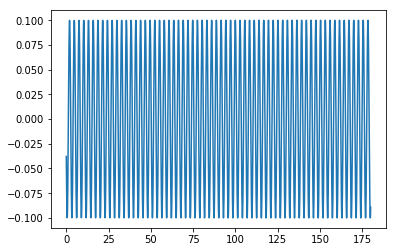

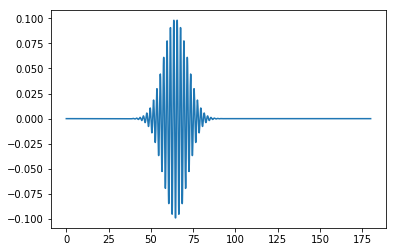

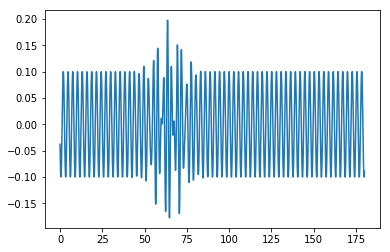

In [5]:
print(ts_s_train.shape)
print(ts_sg_train.shape)
print (ts_mix_train.shape)

# Time series examples

plt.plot(t, ts_s_train[0,:])
plt.show()
plt.plot(t, ts_sg_train[0,:])
plt.show()
plt.plot(t, ts_mix_train[0,:])
plt.show()

## Validation

- 20 mixed signals + clean/target sources signals

### Time series

In [6]:
# Same as training 

ts_s_validation = np.zeros((200,N))
ts_sg_validation = np.zeros((200,N))

# noise
# noise = np.random.normal(loc=0.0, scale=10.0, size=1000)

for i in range(20):
    
    ts_s_validation[i,:] = a*np.sin(2*np.pi*t + phase_shift_sin[i]) #+ noise
    ts_sg_validation[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*f0*(t-t0_sg[i])+phi0)) #+ noise
    
    ts_mix_validation = ts_s_validation + ts_sg_validation

## Testing

- 100 randomly generated useen mixed signals + clean/target sources for evaluation

### Time series

In [7]:
# Time series

ts_s_test = np.zeros((1000,N))
ts_sg_test = np.zeros((1000,N))

# noise
# noise = np.random.normal(loc=0.0, scale=10.0, size=1000)

for i in range(100):
    
    ts_s_test[i,:] = a*np.sin(2*np.pi*t + phase_shift_sin[i]) #+ noise
    ts_sg_test[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*f0*(t-t0_sg[i])+phi0)) #+ noise
    
    ts_mix_test = ts_s_test + ts_sg_test

# Model

- Architecture is the same for each source. One net per source.
- Basically a convolutional AE with 1D input
- Loss function is the mean square error between the output and the clean target.
- Weights initiated randomly

### Time series

In [8]:
class CDAE(nn.Module):
    
    def __init__(self):
        super(CDAE, self).__init__()
        
        self.encoder = nn.Sequential(
            #input size: [batch_size, 1, 1800]
            nn.Conv1d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            # [batch_size, 10, 1800]
            nn.MaxPool1d(kernel_size=6, stride=6, padding=1),
            # [batch_size, 10, 300]
            nn.Conv1d(10, 20, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            # [batch_size, 20, 300]
            nn.MaxPool1d(6, 6, padding=1),
            # [batch_size, 20, 50]
            nn.Conv1d(20, 30, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True)
            # [batch_size, 30, 50]
            
        )
        
        self.decoder = nn.Sequential(
            # [batch_size, 30, 50]
            nn.ConvTranspose1d(30, 20, kernel_size=6, stride=6, bias=False),
            nn.ReLU(True),
            # [batch_size, 20, 300]
            nn.ConvTranspose1d(20, 10, kernel_size=6, stride=6, bias=False),
            nn.ReLU(True),
            # [batch_size, 10, 1800]
            nn.ConvTranspose1d(10, 1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True)
            # [batch_size, 1, 1800]
        )
        
    def forward(self, x):
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x  

torch.Size([1000, 1, 1800])
torch.Size([1000, 10, 1800])
torch.Size([1000, 10, 300])
torch.Size([1000, 1, 1800])


<function matplotlib.pyplot.show(*args, **kw)>

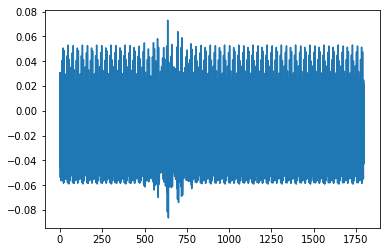

In [9]:
a = Variable(torch.from_numpy(ts_mix_train))
a = a.reshape(-1,1,N)
a = a.type(torch.FloatTensor)
m = nn.Conv1d(1, 10, kernel_size=3, stride=1, padding=1)
m1 = nn.MaxPool1d(6, stride=6, padding=1)
m2 = nn.ConvTranspose1d(10, 1, kernel_size=6, stride=6, padding=0)

b = m(a)
c = m1(b)
d = m2(c)
#e = m2(d)
#f = m2(e)

print(a.size())
print(b.size())
print(c.size())
print(d.size())
#print(e.size())
#print(f.size())


plt.plot(d[0, :, :].reshape(N).detach().cpu().numpy())
plt.show

# Training

In [10]:
# Hyperparameters

num_epochs = 100
batch_size = 100
lr = 0.001

epoch 0, loss 0.0003403176961001009
None


/home/annaf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/annaf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


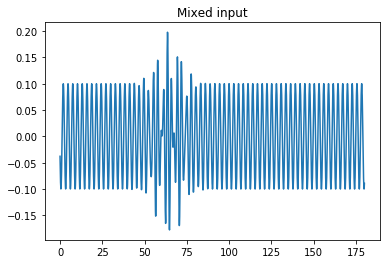

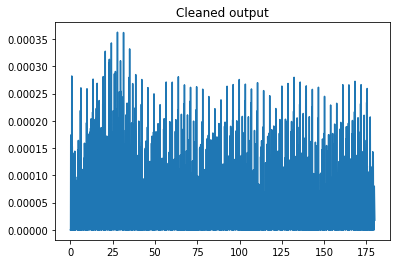

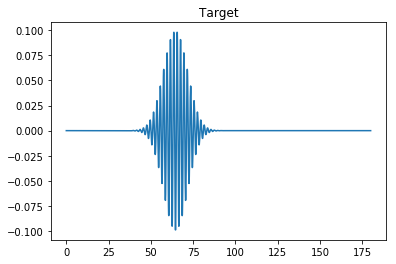

epoch 10, loss 0.00033738321508280933
None


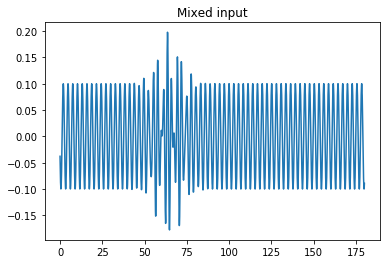

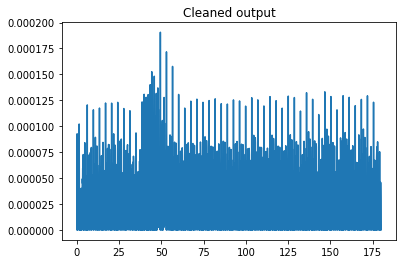

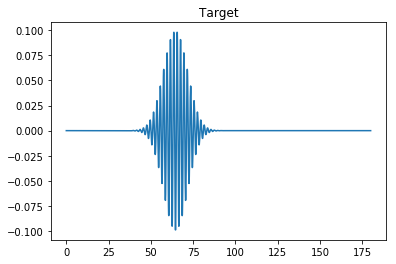

epoch 20, loss 0.0003398840199224651
None


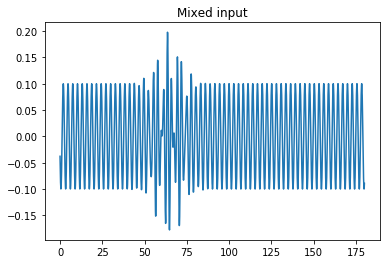

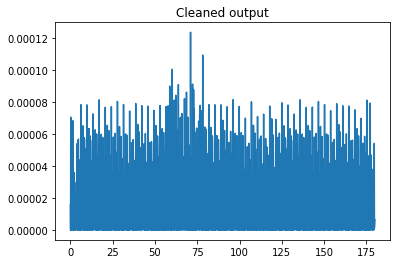

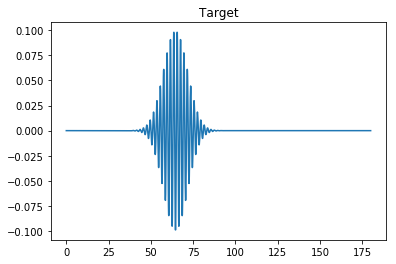

epoch 30, loss 0.00034322089049965143
None


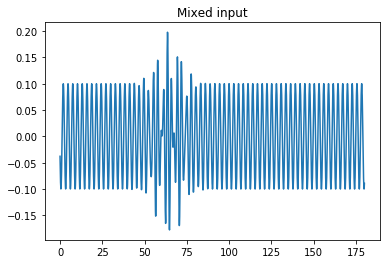

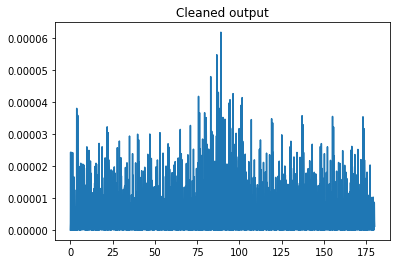

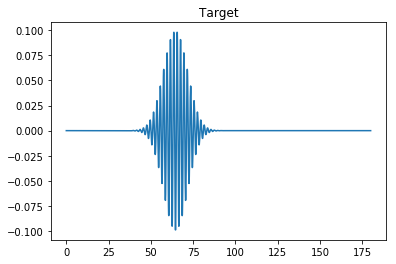

epoch 40, loss 0.0003409583296161145
None


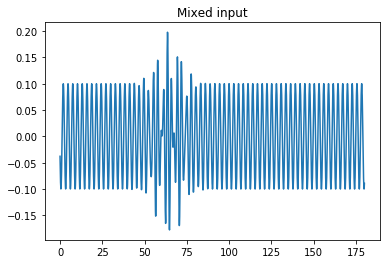

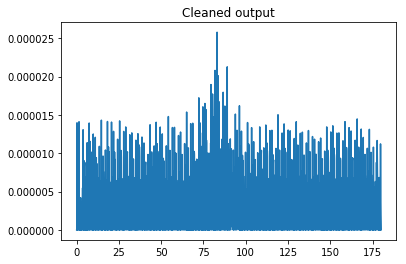

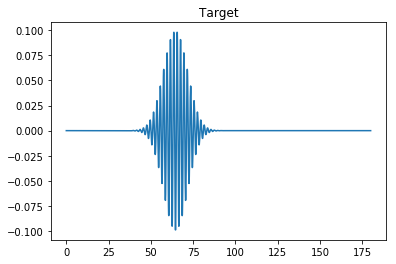

epoch 50, loss 0.0003436809638515115
None


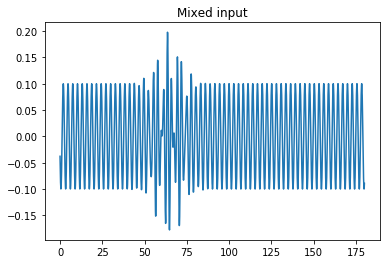

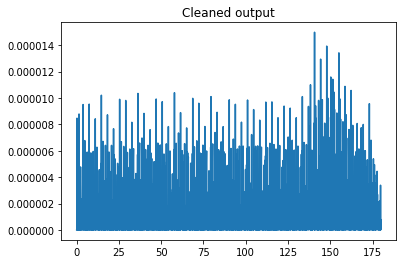

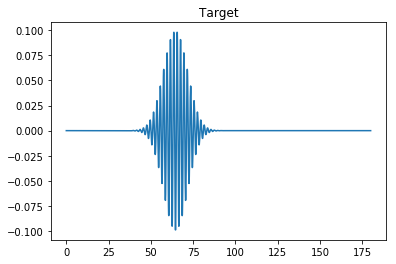

epoch 60, loss 0.0003355778462719172
None


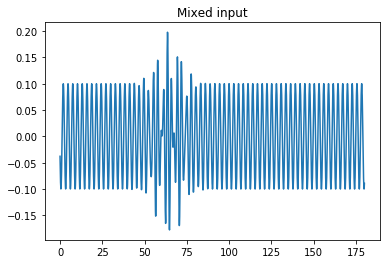

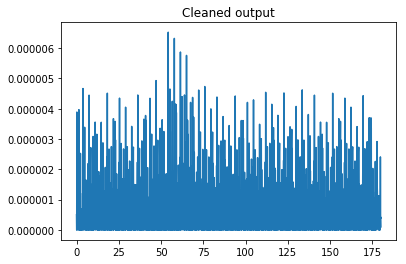

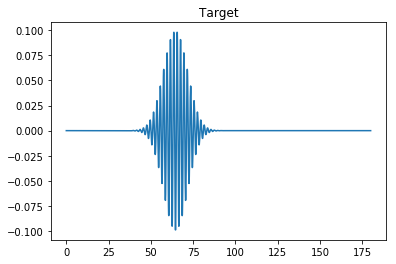

epoch 70, loss 0.0003410885692574084
None


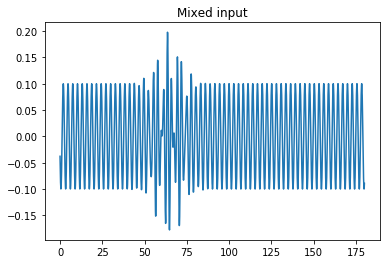

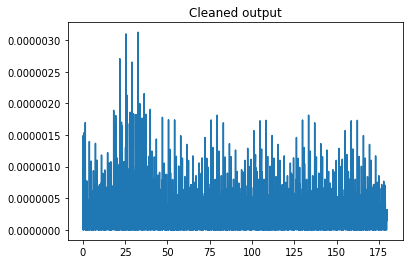

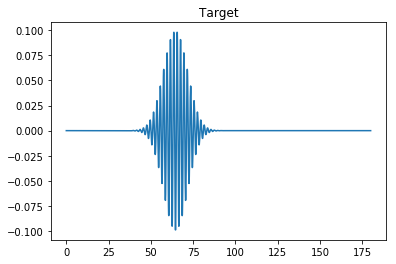

epoch 80, loss 0.0003447734343353659
None


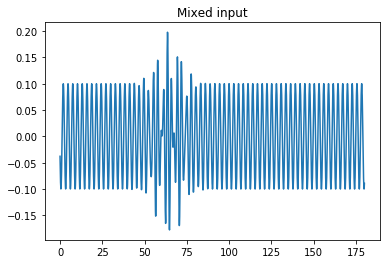

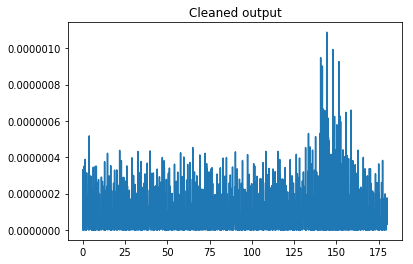

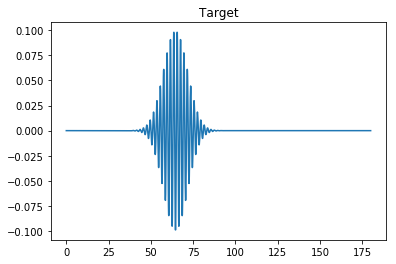

epoch 90, loss 0.00034210016019642353
None


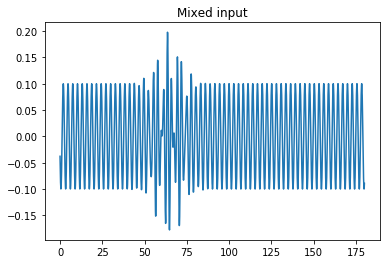

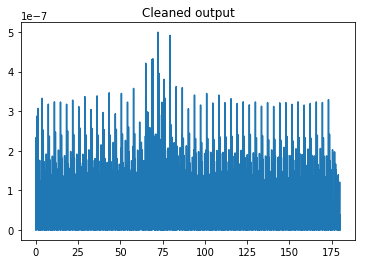

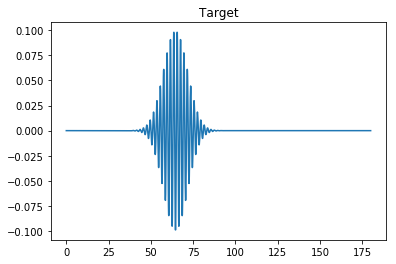

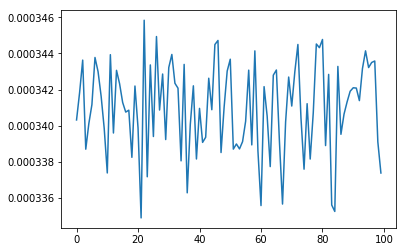

In [12]:
# This net will be trained to separate sine-gaussian waves from the mixed time series

inputs = Variable(torch.from_numpy(ts_mix_train)).to(device)
inputs = inputs.reshape(-1,1,N)
inputs = inputs.type(torch.cuda.FloatTensor)
#inputs = inputs.type(torch.FloatTensor)

sg_net = CDAE().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(sg_net.parameters(), lr=lr, weight_decay=1e-5)
loss_save = []
epoch = 0

for epoch in range(num_epochs):
    
    idx  = random.sample(list(np.arange(inputs.shape[0])),batch_size) # 20 random indices on the 1000 ts 
    
    outputs = sg_net(inputs[idx,:,:])
    
    clean = Variable(torch.from_numpy(ts_sg_train)).to(device)
    clean = clean.reshape(-1,1,N)
    #clean = clean.type(torch.FloatTensor)
    clean = clean.type(torch.cuda.FloatTensor)
    
    
    loss = criterion(outputs, clean[idx,:,:])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_save.append(loss.data[0])
    
    # monitor progress
    if epoch%10==0:
        print(print('epoch {}, loss {}'.format(epoch, loss.data[0])))
        
        plt.plot(t, inputs[0,:,:].reshape(N).cpu().numpy())
        plt.title('Mixed input')
        plt.show()
        plt.plot(t, outputs[0,:,:].reshape(N).detach().cpu().numpy())
        plt.title('Cleaned output')
        plt.show()
        plt.plot(t, clean[0,:,:].reshape(N).cpu().numpy())
        plt.title('Target')
        plt.show()

plt.plot(loss_save)

In [ ]:
# This net will be trained to separate sine waves from the mixed time series

batch_idx  = random.sample(list(np.arange(1000)),batch_size)

sine_net = CDAE().to(device)

#criterion = nn.MSELoss()
optimizer = torch.optim.Adam(sine_net.parameters(), lr=lr)
loss_save = []
epoch = 0

for epoch in range(num_epochs):
    
    epoch += 1
    optimizer.zero_grad()
    loss = 0
    
    for i in batch_idx:
        
        inputs = Variable(torch.from_numpy(ts_mix_train[i, :])).to(device)
        inputs = inputs.reshape(-1,1,N)
        inputs = inputs.type(torch.cuda.FloatTensor)
                          
        outputs = sine_net(inputs)
        
        clean = Variable(torch.from_numpy(ts_s_train[i, :])).to(device)
        clean = clean.reshape(-1,1,N)
        clean = clean.type(torch.cuda.FloatTensor)
        loss = loss + torch.nn.functional.mse_loss(outputs, clean)
    
    loss = loss/batch_size
    loss.backward()
    optimizer.step()
    loss_save.append(loss.data[0])
    
    if epoch%10==0:
        print('epoch {}, loss {}'.format(epoch, loss.data[0]))
        
        plt.plot(t, inputs.reshape(N).cpu().numpy())
        plt.title('Mixed input')
        plt.show()
        plt.plot(t, outputs.reshape(N).detach().cpu().numpy())
        plt.title('Cleaned output')
        plt.show()
        plt.plot(t, clean.reshape(N).cpu().numpy())
        plt.title('Target')
        plt.show()

In [ ]:
plt.plot(loss_save)